## CS4487 Group 6 Project Report
Project Title: DeepFake Detection

Author: Group 6

Date: 10 December, 2023

---

### Table of Contents
0. Setup
1. Group Information
2. Introduction
    1. Background
    2. Project Specification
3. Methodology
    1. Data Organization (combine+proportion)
    2. Binary vs Multiclass Classification
    3. Data Preperation (augmentation)
    4. Fine Tuning
    5. Ensemble Strategies

4. Baseline Model (How we apply tricks in training - use ResNet18 as example)
    1. Training process
    2. Failure Analysis
    3. Data Augmentation Improvement

5. Model Selection (result and summary and hyperparameter tuning)
    1. EfficientNet_v2_s
    2. EfficientNet_v2_m
    3. EfficientNet_v2_l
    4. SE_ResneXt
    5. ViT_b_16
    6. ConvNeXt

6. Experiments
    1. Model Ensemble
    2. Upsampling

7. Submission
    1. Structure
    2.  Performance

8. Conclusion & Discussion

9. Appendix I. References


---
### **0. Group Info**
We are group 6. Our team consists of 3 members:
- Lik Hang Kenny WONG
- Yonge BAI
- Yongjian WU



### **1. Setup**

### TA Guidline:

First initialize the variable `TEST_SET_PATH` to the path of the test set folder which should be in the same structure as the training dataset.

For testing, there are two options: 
1. simply test the final model
2. training (reproducing) the whole model and test it

For testing the final model, initialize the variable `MODE` below as **'test'**. Otherwise, **'train'**.

In [ ]:
TEST_SET_PATH = '../data/test/'

In [ ]:
# Select the mode
# MODE = 'train'
MODE = 'train'

In [ ]:
# If you are in training mode, here is the folder for the training dataset
#  Src training data zip file
zip_path = "project_data.zip"
# Unzipped training data folder
target_folder = "project_data"

In [ ]:
%cd DeepFake_Classification 
%pip install torchvision
%pip install torch 
%pip install albumentations
%pip install opencv-python-headless
%pip install matplotlib
%pip install torchsummary
%pip install torchvision
%pip install torch
%pip install gdown
%pip install timm
%pip install pretrainedmodels
%pip install scikit-learn

In [ ]:
#setup
import os
import shutil
import zipfile
import gdown
#data extraction
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import numpy as np
#data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
#plotting
import matplotlib.pyplot as plt
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import models #import image model for fine tuning
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import math
import timm
import pretrainedmodels
import ssl
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_auc_score,confusion_matrix, classification_report, precision_recall_curve, roc_curve, ConfusionMatrixDisplay
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
import time
import csv



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

### **2. Introduction**

#### **2.1. Background**
Deepfakes are synthetic media in which a person's likeness is replaced with another's, often without the consent of either party. They are produced using artificial intelligence (AI) techniques, particularly deep learning algorithms, hence the name "Deepfakes".​

Deepfakes first emerged in late 2017 on Reddit.​ The technology became more accessible with the release of FakeApp, an easy-to-use platform for creating DeepFake images in 2018.​ As concerns about deepfakes grew, Facebook announced the Deepfake Detection Challenge in partnership with Microsoft and academics in 2019.

Today, anyone with a decent computer and free software can create convincing deepfakes. The field continues to advance, with new and improved methods for both creating and detecting deepfakes. ​Meranwhile, concerns grow about the potential misuse of these technologies in the fields of politics, crime, and misinformation. This has spurred on ongoing research into detection methods as well as discussions about legal and ethical frameworks to govern the use of these technologies. ​With the rise of immoral (illegal) applications of DeepFake techniques, it becomes crucial to have an effective detection tool. ​
    
#### **2.2. Project Specification**
This project is a binary classification problem on a deepfake image dataset. The dataset includes 55138 images of size 317 $ \times $ 317 $ \times $ 3 in total, in which 49061 for training and 6075 for validation. It provides three types of label types including binary labels. manipulation-oriented labels and semantics-oriented labels. Parts of the dataset imagres are preprocessed images wiht adjustments like blurring and compression.

### **3. Methodology**


#### **3.1. Data Organization (combine+proportion)**


In [ ]:
def download_file_from_google_drive(zip_path): #download data from google drive
    url = "https://drive.google.com/uc?id=17AB1ECAtJxKw7TknN697I8VR8PrJ5HxL&confirm=t&uuid=7ce523f8-b085-4cb6-a6b0-53fe331a845a"
    gdown.download(url, zip_path, quiet=False)


def extract_zip(zip_file_path, target_folder): #extract zip file
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(target_folder)

    print(f"Successfully extracted {zip_file_path} to {target_folder}")

Original folder structure:
```
Group Project
│
└── dataset
    │
    ├── train
    │   │
    │   ├── FakeManipulation-1
    │   ├── FakeManipulation-2
    │   ├── FakeManipulation-3
    │   ├── FakeManipulation-4
    │   ├── FakeManipulation-5
    │   ├── Real-1
    │   ├── Real-2
    │   ├── Real-3
    │   └── Real-4
    │
    └── val
        │
        ├── FakeManipulation-1
        ├── FakeManipulation-2
        ├── FakeManipulation-3
        ├── FakeManipulation-4
        ├── FakeManipulation-5
        ├── Real-1
        ├── Real-2
        ├── Real-3
        └── Real-4
```
##### **Step 1**

The first step of data organization is to re-organize the folder structure by flattening the data and combining all real folders.


In [ ]:
def flatten_dir(root_dir): #flatten directory
    unique_names = set()
    for root, dirs, files in os.walk(root_dir, topdown=False):
        for file in files:
            base_name, extension = os.path.splitext(file)
            unique_name = file
            counter = 1
            while unique_name in unique_names:
                unique_name = f"{base_name}_{counter}{extension}"
                counter += 1
            unique_names.add(unique_name)
            source = os.path.join(root, file)
            destination = os.path.join(root_dir, unique_name)
            shutil.move(source, destination)
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            shutil.rmtree(dir_path)


def combine_dirs(folder_paths, target_dir): #combine directories
    unique_names = set()
    os.makedirs(target_dir, exist_ok=True)
    for folder_path in folder_paths:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                base_name, extension = os.path.splitext(file)
                unique_name = file
                counter = 1
                while unique_name in unique_names:
                    unique_name = f"{base_name}_{counter}{extension}"
                    counter += 1
                unique_names.add(unique_name)

                source = os.path.join(root, file)
                destination = os.path.join(target_dir, unique_name)
                shutil.move(source, destination)
    for folder_path in folder_paths:
        shutil.rmtree(folder_path)

In [ ]:
def download_and_organize_data(zip_path, target_folder):
    if not os.path.exists(zip_path):
        download_file_from_google_drive(zip_path)
    if not os.path.exists(target_folder):
        extract_zip(zip_path, target_folder)
    if not os.path.exists(os.path.join(target_folder, "test")):
        os.rename(os.path.join(target_folder, "val"), os.path.join(target_folder, "test"))
        for i in range(5):
            flat_dir = os.path.join(target_folder, "train", f"FakeManipulation-{i+1}")
            flatten_dir(flat_dir)
        for i in range(4):
            flat_dir = os.path.join(target_folder, "train", f"Real-{i+1}")
            flatten_dir(flat_dir)
        for i in range(5):
            flat_dir = os.path.join(target_folder, "test", f"FakeManipulation-{i+1}")
            flatten_dir(flat_dir)
        for i in range(4):
            flat_dir = os.path.join(target_folder, "test", f"Real-{i+1}")
            flatten_dir(flat_dir)
        # combine all real folders
        combine_dirs(
            [os.path.join(target_folder, "train", f"Real-{i+1}") for i in range(4)],
            os.path.join(target_folder, "train", "Real"),
        )
        combine_dirs(
            [os.path.join(target_folder, "test", f"Real-{i+1}") for i in range(4)],
            os.path.join(target_folder, "test", "Real"),
        )

Folder structure after step 1:

```
Group Project
│
└── dataset
    │
    ├── train
    │   │
    │   ├── FakeManipulation-1
    │   ├── FakeManipulation-2
    │   ├── FakeManipulation-3
    │   ├── FakeManipulation-4
    │   ├── FakeManipulation-5
    │   └── Real
    |
    └── val
        │
        ├── FakeManipulation-1
        ├── FakeManipulation-2
        ├── FakeManipulation-3
        ├── FakeManipulation-4
        ├── FakeManipulation-5
        └── Real
```

##### **Step 2**
The second step is data partition.
To identify the optimal hyperparameter configurations, we partitioned our dataset into three distinct subsets: 70% for training, 15% for validation, and 15% for testing. We experimented with various hyperparameter pairings using the training and validation sets. Following this, we evaluated the performance of each combination on the test set. This process enabled us to compare the efficacy of different hyperparameter sets and choose the one that demonstrated superior performance. The val folder originally provided is renamed as "test" and split an amount of data in each labels from Train folder to new "val" folder as validation set.

In [ ]:
def train_val_split(root_path, file_num, split_path):
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    files = os.listdir(root_path)
    for i in range(file_num):
        # randomly choose a file
        file = np.random.choice(files)
        files.remove(file)
        # move file to split path
        source = os.path.join(root_path, file)
        destination = os.path.join(split_path, file)
        shutil.move(source, destination)

def create_validation_set(target_folder):
    if not os.path.exists(os.path.join(target_folder, "val")):
        for i in range(5):
            train_val_split(
                os.path.join(target_folder, "train", "FakeManipulation-" + str(i+1)),
                650,
                os.path.join(target_folder, "val", "FakeManipulation-" + str(i+1)),
            )

        train_val_split(
            os.path.join(target_folder, "train", "Real"),
            3565,
            os.path.join(target_folder, "val", "Real"),
        )

Folder structure after step 2:
```
Group Project
│
└── dataset
    │
    ├── train
    │   │
    │   ├── FakeManipulation-1
    │   ├── FakeManipulation-2
    │   ├── FakeManipulation-3
    │   ├── FakeManipulation-4
    │   ├── FakeManipulation-5
    │   └── Real
    |
    ├── val
    │   │
    │   ├── FakeManipulation-1
    │   ├── FakeManipulation-2
    │   ├── FakeManipulation-3
    │   ├── FakeManipulation-4
    │   ├── FakeManipulation-5
    │   └── Real
    │
    └── test
        │
        ├── FakeManipulation-1
        ├── FakeManipulation-2
        ├── FakeManipulation-3
        ├── FakeManipulation-4
        ├── FakeManipulation-5
        └── Real
```

| Category             | Before Splitting (Train) | After Splitting (Train) | After Splitting (Val) | After Splitting (Test) |
|----------------------|--------------------------|-------------------------|-----------------------|------------------------|
| Real                 | 24512                    | 20947                   | 3565                  | 3008                   |
| FakeManipulation-1   | 4802                     | 4152                    | 650                   | 600                    |
| FakeManipulation-2   | 5226                     | 4576                    | 650                   | 653                    |
| FakeManipulation-3   | 4884                     | 4234                    | 650                   | 610                    |
| FakeManipulation-4   | 5149                     | 4499                    | 650                   | 643                    |
| FakeManipulation-5   | 4288                     | 3838                    | 650                   | 561                    |
| Total                | 47061                    | 42246                   | 6815                  | 6075                   |

In [ ]:
if MODE == 'train':
    download_and_organize_data(zip_path, target_folder)

#### **3.2. Binary vs Multiclass Classification**
Since apart from binary labels, multiclass labels are provided, our next step in this project is to test out and compare both binary classification (combining 5 fake-labels as one label) and multi-class classification. We used ResNet18 with finetuning on training dataset as our base model to perform this experiment. The result obtained below shows us that we can obtain a much higher accuracy with multi-class classification than binary classification

We first configured our Dataset to make it be able to do both binary classification and multiclass classification:

In [ ]:
class ImageFolder(Dataset):
    def __init__(self, root, transform=None, classification_mode='multiclass'):
        self.root = root
        self.transform = transform
        self.classification_mode = classification_mode
        self.samples = []
        self.targets = []
        self.imgs = []
        self.classes = []
        self.class_to_idx = {} 
        self.idx_to_class = {}
        self._find_classes()
        self._make_dataset()

    def _find_classes(self):
        classes = [d.name for d in os.scandir(self.root) if d.is_dir()]
        classes.sort()
        self.classes = classes
        if self.classification_mode == 'binary':
            self.class_to_idx = {cls_name: 0 if 'Fake' in cls_name else 1 for cls_name in classes}
            self.original_class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            self.idx_to_class = {0: 'Fake', 1: 'Real'}
            self.original_idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}
        else:
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            self.idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}
    def _make_dataset(self):
        for target_class in self.class_to_idx.keys():
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.root, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    self.samples.append(path)
                    self.targets.append(class_index)
                    self.imgs.append(fname)

    def __getitem__(self, index):
        path = self.samples[index]
        target = self.targets[index]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)

        if self.transform is not None:
            transformed = self.transform(image=np.array(img_pil)) #added this one
            img = transformed['image']

        return img, target

    def __len__(self):
        return len(self.samples)

Using the most basic augmentation, normalized with pixel-level mean and standard deviation of the dataset

In [ ]:
transforms = {
    "train_transform": A.Compose(
        [
            A.HorizontalFlip(p=0.5), # apply horizontal flip only
            A.Normalize(mean=(0.4659, 0.4310, 0.4056), std=(0.2161, 0.2032, 0.1986)), #
            ToTensorV2(),
        ]
    ),
    "test_transform": A.Compose(
        [
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    ),
}

##### **Binary Classification**

Label mapping:

| Category             | Label |
|----------------------|-------|
| FakeManipulation-1   | 0     |
| FakeManipulation-2   | 0     |
| FakeManipulation-3   | 0     |
| FakeManipulation-4   | 0     |
| FakeManipulation-5   | 0     |
| Real                 | 1     |

Experiments results:
| Epoch | Loss     | Training Accuracy | Testing Accuracy |
|-------|----------|-------------------|------------------|
| 1/20  | 637.4761 | 68.09%            | 75.49%           |
| 2/20  | 301.8076 | 81.85%            | 81.09%           |
| 3/20  | 212.8558 | 88.08%            | 85.68%           |
| 4/20  | 151.5400 | 91.88%            | 86.11%           |
| 5/20  | 111.2383 | 94.20%            | 86.29%           |
| 6/20  | 87.7512  | 95.53%            | 89.28%           |
| 7/20  | 72.7245  | 96.46%            | 89.07%           |
| 8/20  | 62.5806  | 96.94%            | 91.56%           |
| 9/20  | 55.5184  | 97.27%            | 90.86%           |
| 10/20 | 49.6251  | 97.64%            | 90.96%           |
| 11/20 | 45.3451  | 97.78%            | 92.05%           |
| 12/20 | 41.8547  | 98.00%            | 90.86%           |
| 13/20 | 39.1265  | 98.11%            | 91.18%           |
| 14/20 | 36.6206  | 98.26%            | 90.85%           |
| 15/20 | 36.1308  | 98.29%            | 91.28%           |
| 16/20 | 34.3273  | 98.37%            | 92.26%           |
| 17/20 | 31.2315  | 98.46%            | 91.95%           |
| 18/20 | 28.1377  | 98.70%            | 91.75%           |
| 19/20 | 29.6406  | 98.57%            | 92.59%           |
| 20/20 | 26.4991  | 98.77%            | 91.03%           |


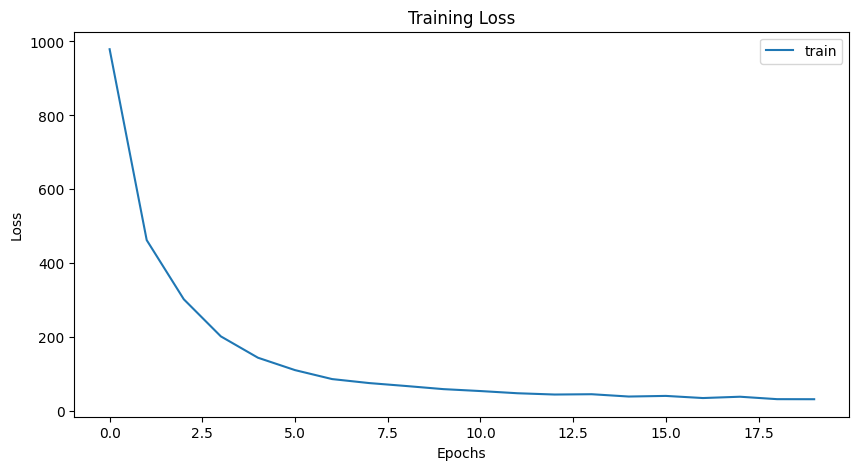

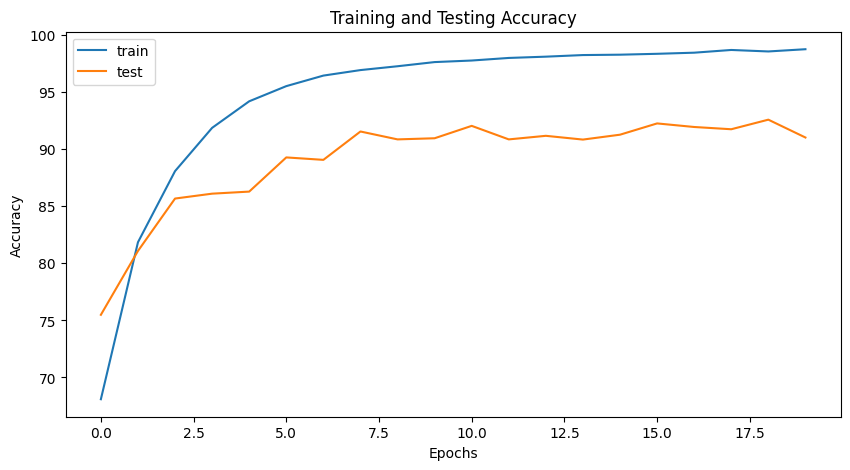

Test set performance:

In the testing, we will use the model obtained from the epoch giving the best validation accuracy.
| Metric    | Value     |
|-----------|-----------|
| Accuracy  | 91.8230%  |
| Recall    | 91.02245  |
| Precision | 90.05259  |
| AUC       | 92.12331  |

##### **Multi-class Classification:**

Label mapping:

| Category             | Label |
|----------------------|-------|
| FakeManipulation-1   | 0     |
| FakeManipulation-2   | 1     |
| FakeManipulation-3   | 2     |
| FakeManipulation-4   | 3     |
| FakeManipulation-5   | 4     |
| Real                 | 5     |

##### **training with training set and validating on validation set:**

Experiment results:

| Epoch   | Loss     | Training Accuracy | Testing Accuracy |
|---------|----------|-------------------|------------------|
| 1/20    | 979.0731 | 61.17%            | 67.77%           |
| 2/20    | 462.5699 | 78.18%            | 77.79%           |
| 3/20    | 302.5614 | 86.07%            | 83.05%           |
| 4/20    | 202.1024 | 90.80%            | 85.51%           |
| 5/20    | 144.3845 | 93.40%            | 84.79%           |
| 6/20    | 110.8465 | 94.84%            | 87.01%           |
| 7/20    | 86.5954  | 96.21%            | 88.86%           |
| 8/20    | 75.8047  | 96.60%            | 87.88%           |
| 9/20    | 67.8241  | 96.92%            | 88.31%           |
| 10/20   | 59.4131  | 97.27%            | 89.53%           |
| 11/20   | 54.2111  | 97.61%            | 88.12%           |
| 12/20   | 48.2593  | 97.80%            | 88.71%           |
| 13/20   | 44.8048  | 97.92%            | 89.12%           |
| 14/20   | 45.6240  | 97.96%            | 89.43%           |
| 15/20   | 39.3832  | 98.29%            | 88.81%           |
| 16/20   | 41.0700  | 98.09%            | 90.63%           |
| 17/20   | 35.3018  | 98.44%            | 89.70%           |
| 18/20   | 38.8561  | 98.23%            | 90.58%           |
| 19/20   | 32.2735  | 98.54%            | 90.35%           |
| 20/20   | 32.1061  | 98.58%            | 90.75%           |

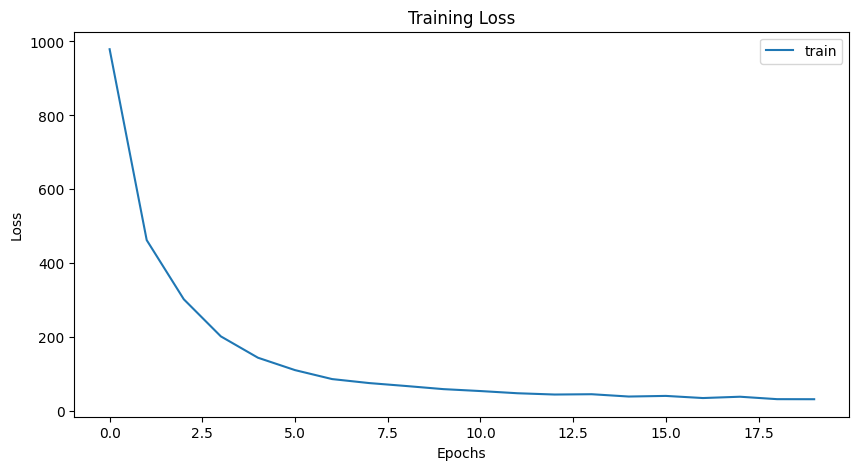

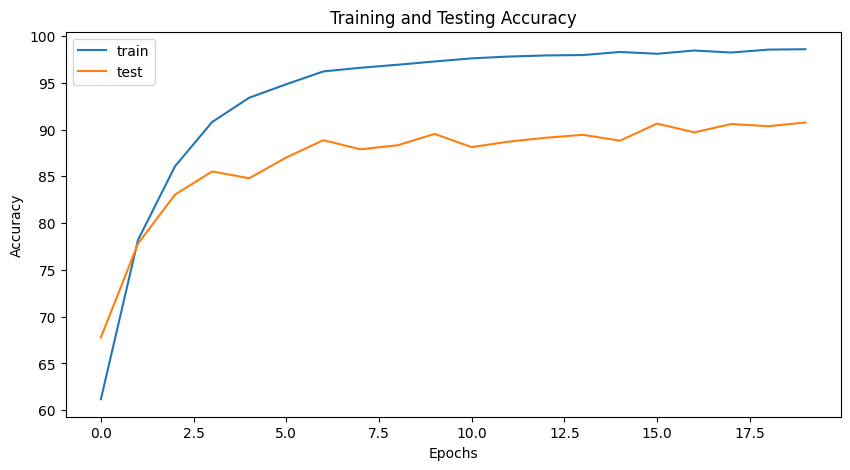

### Analysis of Curves
Looking at our Accuracy vs Epochs curve, we can see that we have a large gap between testing and training accuracy. This indictes that our model is overfitting and would benefit from more data or regularization [1]

In the testing of multiclass classification, we will set the prediction of different fake labels as the same fake label with the following function:

In [ ]:
def transfer_multi_class_to_binary(labels, predictions):
    labels = (labels < 5).long()
    predictions = (predictions < 5).long()

    return labels, predictions

Test set performance:

In the testing, we will use the model obtained from the epoch giving the best validation accuracy.

| Metric    | Value    |
|-----------|----------|
| Accuracy  | 93.03704 |
| Recall    | 93.02535 |
| Precision | 93.06658 |
| AUC       | 93.02535 |

##### **Conclusion**
Training a multi-class classifier and then apply it to binary classification problem can perform better than training a binary classifier solely. Hence we will stick with training multi-class classifiers.

Overfitting occurs for both models, proper techniques including hyperparameters tuning, and regularization like data augmentation should be performed.

Baseline performance: We should look for higher performance models than result obtained from this multi-class classification.

#### **3.3. Data Preperation**
##### **Step 1: Data Augmentation**
As the baseline model suffered from serious overfitting, we looked into the dataset and have observed that numerous image data seems to have been augmented, we then made use of Albumentation library to define a set of transformation based on the observable augmentation, to make the model more robust to these transformation and focus more on the manipulation details

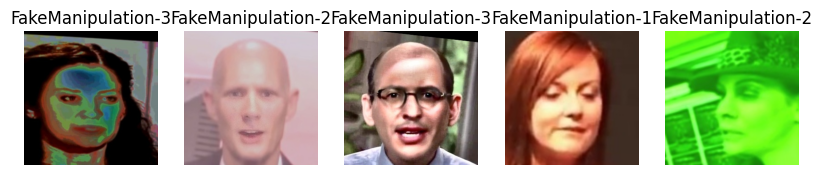

We then defined a set of transformation in  `transform2` based on observed data

In [ ]:
# insert code here
transforms = {
    "transform1": A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.4659, 0.4310, 0.4056), std=(0.2161, 0.2032, 0.1986)),
            ToTensorV2(),
        ]
    ),
    "transform2": A.Compose([
            A.GaussNoise(p=0.1),
            A.GaussianBlur(p=0.1),
            A.CoarseDropout(max_height=16, max_width=16),
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
    ]),
    "test_transform": A.Compose(
        [
            A.Normalize(mean=(0.4659, 0.4310, 0.4056), std=(0.2161, 0.2032, 0.1986)),
            ToTensorV2(),
        ]
    ),
}

##### **Step 2: Dataset Building and Loading**

In [ ]:
# # Define the batch size
batch_size = 32

#### **3.4. Fine Tuning**
We considered 2 routes, either training a model from scatch or choosing a pretrained model and finetuning. Ultimately we chose to go with a pretrained model as pretrained models can capture and leverage meaningful low-level features. Finetuning also let us move fast, as finetuning requires less epochs to converge compared to training from scratch. Finally pretrained models also preform better on Deep Fake detection as tested in DeepfakeBench on a variety of datasets [2].

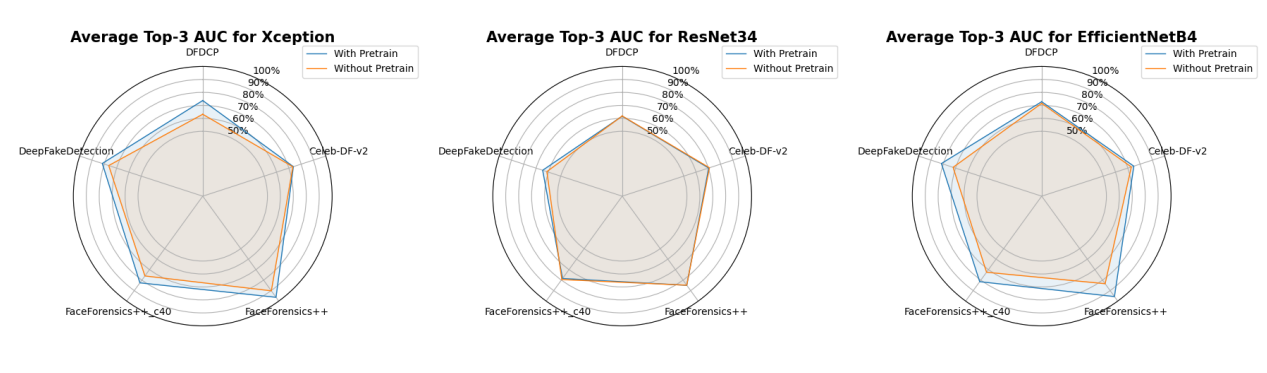

#### **3.5. Ensemble Strategies**
Following in the foot steps of multiple deep fake classification competition winners [3][4], we chose to use an ensemble strategy

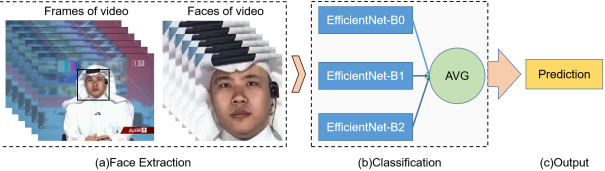

### 3.5.1 Ensemble Experiments
Baseline:
For our baseline we took the probabilities of each class for each model in our ensemble and took the mean, similar to the image above. The class with the highest mean probability we used as our prediction.
```python
class Ensemble(nn.Module):
    def __init__(self, models):
        super(Ensemble, self).__init__()
        self.models = [model.to(device) for model in models]
    
    def forward(self, x):
        probs = [torch.softmax(model(x), dim=1) for model in self.models]
        mean = torch.mean(torch.stack(probs), dim=0)
        return mean
```

We tried out a variety of experiments using our ensemble models including:

1. Max probaility
    - Where we take the class with the highest predicted probability from each model and use that as our prediction
    ```python
    class Ensemble(nn.Module):
        def __init__(self, models):
            super(Ensemble, self).__init__()
            self.models = [model.to(device) for model in models]
        
        def forward(self, x):
            preds = [torch.argmax(torch.softmax(model(x), dim=1), dim=1) for model in self.models]
            max_prob, _ = torch.max(torch.stack(probs), dim=0)
            return max_prob

    ```
   - Result: worse preformance than baseline
  
2. Softmax with temperature
   - We added a temperature value to our softmax function between by testing a range of values in [0.5, 2]
     - lower values increase confidence in higher confidence classes and decrease confidence in decrease confidence classes
     - ex. temp = 0.5,    
       - [0.6, 0.4] -> [1.2, 0.8]  (confidence being greater than 1 is ok since we predict the class with highest value)
     - while higher temperature does the opposite
     - ex temp = 2
       - [0.6, 0.4] -> [0.3, 0.2]
    ```python
    class Ensemble(nn.Module):
        def __init__(self, models, temp):
            super(Ensemble, self).__init__()
            self.models = [model.to(device) for model in models]
            self.temp = temp
        
        def forward(self, x):
            probs = [torch.softmax(model(x)/temp, dim=1) for model in self.models]
            vote = torch.mode(torch.stack(probs), dim=0)
            return vote
    ```
   - Result: We found that temperatures near 1 (no temp) preformed best and did not include it
3.  Weighted probability
    -  We added weight to each models predicted probability, giving higher weight to better preforming models on the validation set
    ```python
    class Ensemble(nn.Module):
        def __init__(self, models, weights):
            super(Ensemble, self).__init__()
            self.models = [model.to(device) for model in models]
            self.weights = weights

        def forward(self, x):
            probs = [torch.softmax(model(x)/weight, dim=1) for (model, weight) in zip(self.models, self.weights)]
            mean = torch.mean(torch.stack(probs), dim=0)
            return mean
    ```
    - Result: We found that this preformed worse than the baseline

Ultimately our baseline method of taking the mean class probabilities from each model preformed best

### **4. Baseline Model (How we apply tricks in training - use ResNet18 as example)**

For our project, we've selected ResNet18 to serve as the baseline model because it is quuick to train. This allows us to establish a minimum accuracy threshold quickly that we aim to exceed with our final outcome. We also used adamW as our default optimizer.

We recognize the significance of selecting a suitable learning rate to enhance the learning efficiency of models. To this end, we are employing an iterative method, systematically testing the values `1e-1, 1e-2, 1e-3, 1e-4, 1e-5` in sequence to identify a learning rate that may optimize the model's performance.

#### **4.1. Training Process**

In [ ]:
import torch.nn.functional as F
import time
from sklearn.metrics import roc_auc_score
import gc


# Train function
def train_model(
    model,
    num_epochs,
    optimizer,
    scheduler,
    criterion,
    train_dataloader,
    test_dataloader,
    model_id,
):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")
    gc.collect()
    torch.cuda.empty_cache()
    model.to(device)

    records = {
        "train_losses": [],
        "train_accuracies": [],
        "test_accuracies": [],
        "train_auc": [],
        "test_auc": [],
        "eval_scores": [],
    }
    start_time = time.time()
    best_eval_score = 0.0

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"Running Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        y_true_train = []
        y_pred_train = []

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

        train_accuracy = correct / total
        train_auc = roc_auc_score(
            y_true_train, y_pred_train, multi_class="ovr", average="weighted"
        )
        records["train_losses"].append(train_loss)
        records["train_accuracies"].append(train_accuracy)
        records["train_auc"].append(train_auc)

        with torch.no_grad():
            model.eval()
            test_correct = 0
            test_total = 0
            y_true_test = []
            y_pred_test = []
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                y_true_test.extend(labels.cpu().numpy())
                y_pred_test.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

        scheduler.step()

        test_accuracy = test_correct / test_total
        test_auc = roc_auc_score(
            y_true_test, y_pred_test, multi_class="ovr", average="weighted"
        )
        records["test_accuracies"].append(test_accuracy)
        records["test_auc"].append(test_auc)

        eval_score = test_auc * 0.7 + test_accuracy * 0.3
        records["eval_scores"].append(eval_score)

        if eval_score > best_eval_score:
            best_eval_score = eval_score
            torch.save(
                model.state_dict(),
                f"best_{model_id}.pth",
            )

        # saving every 10 epochs incase of overfitting ADJUST IF NEEDED
        elif not epoch % 10:
            torch.save(
                model.state_dict(),
                f"epoch_{epoch}_{model_id}.pth",
            )
        epoch_end_time = time.time()

        print(
            f"Epoch {epoch + 1}/{num_epochs} | Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f} | Testing Accuracy: {test_accuracy:.4f} | Training AUC: {train_auc:.4f} | Testing AUC: {test_auc:.4f} | Eval Score: {eval_score:.5f} | Epoch time: {epoch_end_time-epoch_start_time:.2f}"
        )

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return records

Results:

| Learning Rate |Epoch | Loss      | Training Accuracy | Testing Accuracy | Training AUC | Testing AUC |
|---------------|------|-----------|-------------------|------------------|--------------|-------------|
| **1e-1**      | 1/5  | 18851.5642| 46.17%            | 52.30%           | 0.50         | 0.51        |
|               | 2/5  | 1997.5847 | 49.58%            | 52.31%           | 0.50         | 0.50        |
|               | 3/5  | 1997.7109 | 49.58%            | 52.31%           | 0.50         | 0.48        |
|               | 4/5  | 2006.1216 | 49.58%            | 52.31%           | 0.50         | 0.51        |
|               | 5/5  | 2009.0704 | 49.44%            | 52.31%           | 0.50         | 0.50        |
| **1e-2**      | 1/5  | 2481.1129 | 48.69%            | 52.31%           | 0.50         | 0.50        |
|               | 2/5  | 1990.5352 | 49.57%            | 52.18%           | 0.50         | 0.52        |
|               | 3/5  | 1987.2471 | 49.56%            | 52.31%           | 0.51         | 0.52        |
|               | 4/5  | 1987.5772 | 49.58%            | 52.31%           | 0.50         | 0.50        |
|               | 5/5  | 1988.6825 | 49.58%            | 52.31%           | 0.50         | 0.52        |
| **1e-3**      | 1/5  | 2050.4900 | 49.16%            | 52.31%           | 0.51         | 0.56        |
|               | 2/5  | 1997.9181 | 49.58%            | 52.31%           | 0.51         | 0.53        |
|               | 3/5  | 1997.9944 | 49.56%            | 52.31%           | 0.50         | 0.53        |
|               | 4/5  | 1991.9032 | 49.58%            | 52.31%           | 0.52         | 0.56        |
|               | 5/5  | 1985.5520 | 49.58%            | 52.31%           | 0.53         | 0.57        |
| **1e-4**      | 1/5  | 1690.8234 | 53.34%            | 62.47%           | 0.73         | 0.83        |
|               | 2/5  | 1304.2539 | 63.48%            | 69.10%           | 0.84         | 0.88        |
|               | 3/5  | 1096.6253 | 69.26%            | 75.07%           | 0.89         | 0.92        |
|               | 4/5  | 912.8543  | 74.53%            | 76.73%           | 0.92         | 0.93        |
|               | 5/5  | 756.5479  | 78.53%            | 80.44%           | 0.94         | 0.95        |
| **1e-5**      | 1/5  | 1922.1937 | 48.63%            | 54.92%           | 0.63         | 0.74        |
|               | 2/5  | 1645.5683 | 54.24%            | 61.04%           | 0.75         | 0.81        |
|               | 3/5  | 1485.7054 | 58.18%            | 64.31%           | 0.80         | 0.85        |
|               | 4/5  | 1368.3416 | 61.24%            | 66.87%           | 0.83         | 0.87        |
|               | 5/5  | 1296/8350 | 63.59%            | 68.42%           | 0.85         | 0.88        |

We can observe that the loss begins to diminish significantly once the learning rate is set to `1e-4`, indicating that this learning rate is more effective for the model to converge. Consequently, we should consider using `1e-4` as the starting point for further training anad optimization of this model.

Next step, we trained the resnet18 model again with learning rate set to `1e-4` for adamW optimizer

| Epoch | Loss      | Training Accuracy | Testing Accuracy | Training AUC | Testing AUC |
|-------|-----------|-------------------|------------------|--------------|-------------|
| 1/35  | 1766.3236 | 51.74%            | 58.93%           | 0.70         | 0.80        |
| 2/35  | 1437.6527 | 59.58%            | 66.41%           | 0.81         | 0.87        |
| 3/35  | 1270.7202 | 64.10%            | 72.16%           | 0.85         | 0.90        |
| 4/35  | 1140.7560 | 67.66%            | 71.78%           | 0.88         | 0.91        |
| 5/35  | 1038.6046 | 70.66%            | 74.31%           | 0.90         | 0.93        |
| 6/35  | 958.8257  | 73.11%            | 76.83%           | 0.91         | 0.94        |
| 7/35  | 879.9619  | 75.48%            | 78.08%           | 0.93         | 0.94        |
| 8/35  | 817.2277  | 77.10%            | 78.40%           | 0.94         | 0.95        |
| 9/35  | 745.0595  | 79.28%            | 83.68%           | 0.95         | 0.96        |
| 10/35 | 695.8180  | 80.39%            | 82.76%           | 0.95         | 0.96        |
| 11/35 | 641.8622  | 82.12%            | 84.33%           | 0.96         | 0.97        |
| 12/35 | 591.5260  | 83.57%            | 85.65%           | 0.97         | 0.97        |
| 13/35 | 542.1956  | 84.99%            | 86.15%           | 0.97         | 0.97        |
| 14/35 | 506.5254  | 86.03%            | 86.12%           | 0.97         | 0.97        |
| 15/35 | 458.9740  | 87.38%            | 87.94%           | 0.98         | 0.98        |
| 16/35 | 420.1589  | 88.59%            | 88.36%           | 0.98         | 0.98        |
| 17/35 | 389.0280  | 89.23%            | 88.48%           | 0.98         | 0.98        |
| 18/35 | 358.1057  | 90.30%            | 89.77%           | 0.99         | 0.98        |
| 19/35 | 326.9619  | 91.11%            | 90.11%           | 0.99         | 0.98        |
| 20/35 | 297.6460  | 91.72%            | 90.43%           | 0.99         | 0.98        |
| 21/35 | 279.5404  | 92.48%            | 90.62%           | 0.99         | 0.99        |
| 22/35 | 250.9825  | 93.29%            | 91.24%           | 0.99         | 0.99        |
| 23/35 | 235.9628  | 93.68%            | 91.43%           | 0.99         | 0.99        |
| 24/35 | 218.9937  | 94.17%            | 91.94%           | 0.99         | 0.99        |
| 25/35 | 204.9591  | 94.50%            | 92.47%           | 1.00         | 0.99        |
| 26/35 | 195.3686  | 94.79%            | 92.74%           | 1.00         | 0.99        |
| 27/35 | 189.2409  | 95.01%            | 92.74%           | 1.00         | 0.99        |
| 28/35 | 184.6282  | 95.12%            | 92.63%           | 1.00         | 0.99        |
| 29/35 | 183.0227  | 95.16%            | 92.82%           | 1.00         | 0.99        |
| 30/35 | 178.5231  | 95.25%            | 92.93%           | 1.00         | 0.99        |
| 31/35 | 179.0300  | 95.35%            | 92.87%           | 1.00         | 0.99        |
| 32/35 | 180.8205  | 95.30%            | 92.81%           | 1.00         | 0.99        |
| 33/35 | 172.6138  | 95.38%            | 92.75%           | 1.00         | 0.99        |
| 34/35 | 176.9874  | 95.28%            | 92.65%           | 1.00         | 0.99        |
| 35/35 | 176.7607  | 95.36%            | 92.90%           | 1.00         | 0.99        |

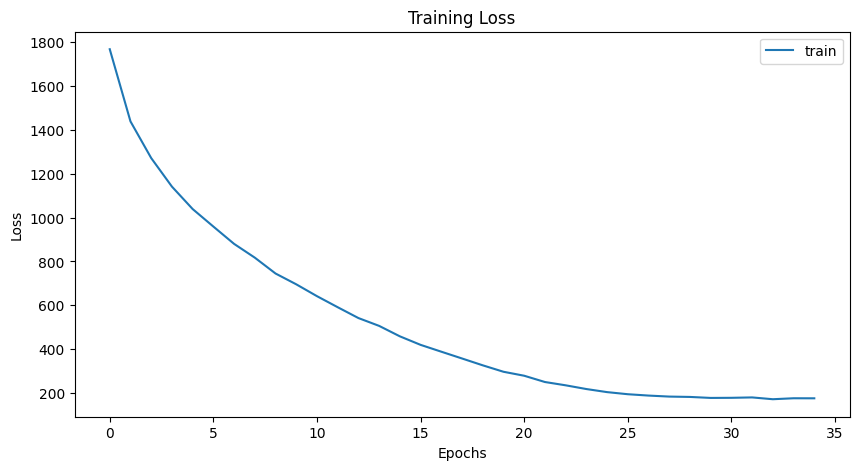
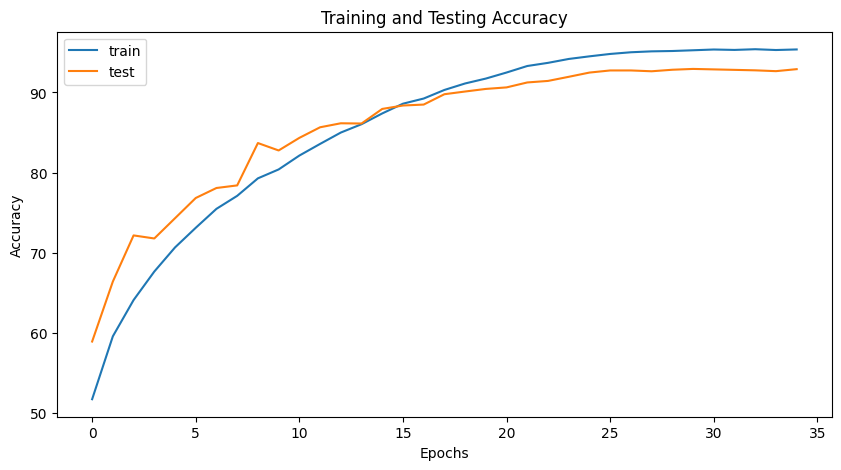
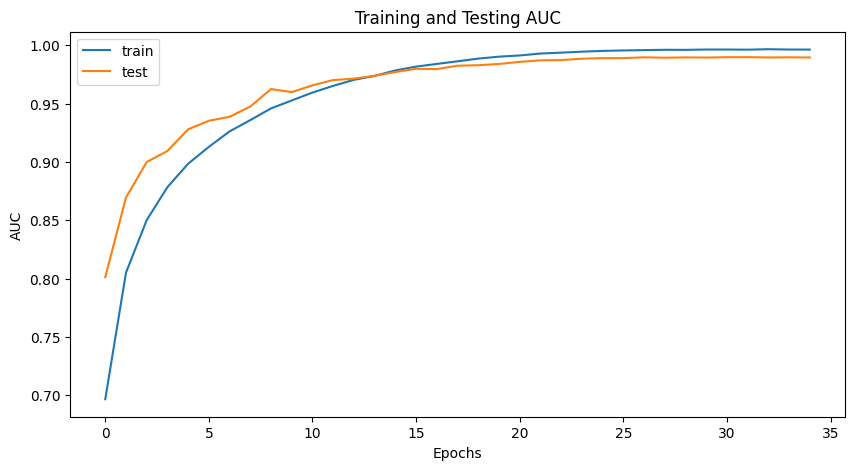

| Metric    | Value    |
|-----------|----------|
| Accuracy  | 93.33414 |
| Recall    | 93.09515 |
| Precision | 93.00678 |
| AUC       | 93.02432 |

So far, the highest testing accuracy achieved by this model is `93.33414`. Enhancements such as implementing Learning Rate schedulers, specifically `stepLR` and `CosineAnnealingLR`, could aid in pushing the model past local optima. Nevertheless, considering that this model is intended as a baseline, we did not apply further methods into its training process. Instead, we plan to employ the same strategies utilized in training this ResNet model to train other models, adding any necessary additional techniques.

#### **4.2. Testing**

In [ ]:
def test(model, test_dataloader):
    model.eval()
    y_hat = []
    y_pred = []
    X_test = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            X_test.extend(images.cpu().numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            labels, predictions = transfer_multi_class_to_binary(labels, predictions)

            y_hat.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(y_hat, y_pred)
    recall = recall_score(y_hat, y_pred, average="macro")
    precision = precision_score(y_hat, y_pred, average="macro")
    auc = roc_auc_score(y_hat, y_pred, multi_class="ovr", average="macro")
    print(f"Accuracy: {round(accuracy*100, 5)}")
    print(f"Recall: {round(recall*100, 5)}")
    print(f"Precision: {round(precision*100, 5)}")
    print(f"AUC: {round(auc*100, 5)}")
    return X_test,y_hat, y_pred, accuracy, recall, precision, auc

#### **4.2. Failure Analysis**

Then we do failure analysis after the full training. 

In [ ]:
def failure_analysis(y_hat,y_pred):
    # Classification report
    print(classification_report(y_hat, y_pred))

    # Plot confusion matrix
    cnf_matrix = confusion_matrix(y_hat, y_pred)
    cm_display = ConfusionMatrixDisplay(cnf_matrix).plot()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_hat, y_pred)

    plt.plot([0, 1.1], [0, 1.1])
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


    # PR curve
    precision, recall, _ = precision_recall_curve(y_hat, y_pred)  
    plt.plot(recall, precision)
    plt.title("PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

In [ ]:
def plot_sample_images(X_test,y_hat, y_pred, type, num=5):
    
    y_pred = torch.from_numpy(np.array(y_pred))
    y_hat = torch.from_numpy(np.array(y_hat))
    X_test = torch.from_numpy(np.array(X_test))

    n = num
    col_num = 5
    row_num = math.ceil(n/col_num)
    
    if type == "TP":
        target = (y_hat == y_pred) == (y_hat == 1)
    elif type == "TN":
        target = (y_hat == y_pred) == (y_hat == 0)
    elif type == "FP":
        target = (y_hat != y_pred) == (y_hat == 1)
    elif type == "FN":
        target = (y_hat != y_pred) == (y_hat == 0)
    target_indices = torch.where(target)[0]
    random_indices = torch.randperm(len(target_indices))[:n]
    target_samples = target_indices[random_indices]

    plt.figure(figsize=(10,10/col_num*row_num))
    for i, idx in enumerate(target_samples):
        img = X_test[idx].cpu().permute(1, 2, 0)
        plt.subplot(row_num, col_num, i+1)
        plt.title(f'{type} images {i+1}')
        plt.imshow(img)

    plt.tight_layout()
    plt.show()

**Confusion Matrix**

Looking at our confusion matrix, we see we have a similar number of FP and FN, indicate tha the model is making similar errors in both directions. Meaning it is not biased towards any class. We interpret this as the quality of the images leading to misclassifictions.

Here is a sample confusion matrix:

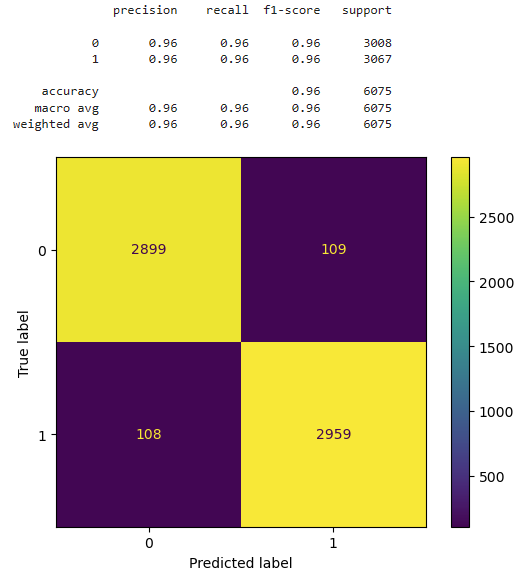

Here are some sample misclassified images:

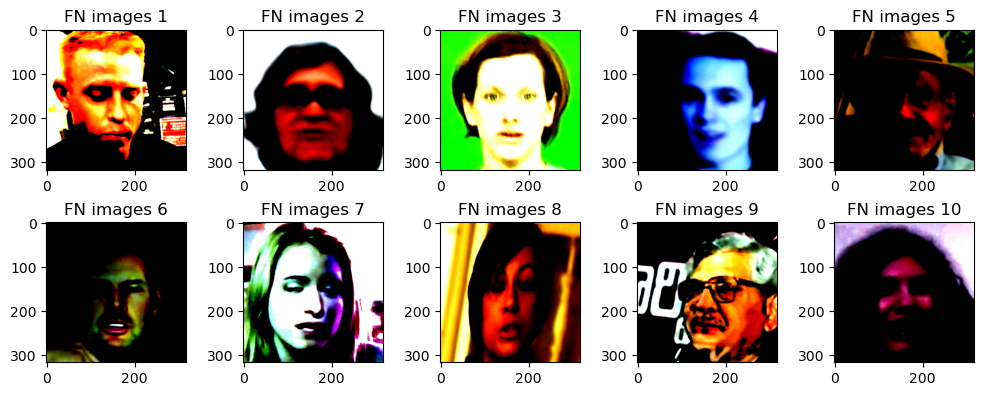
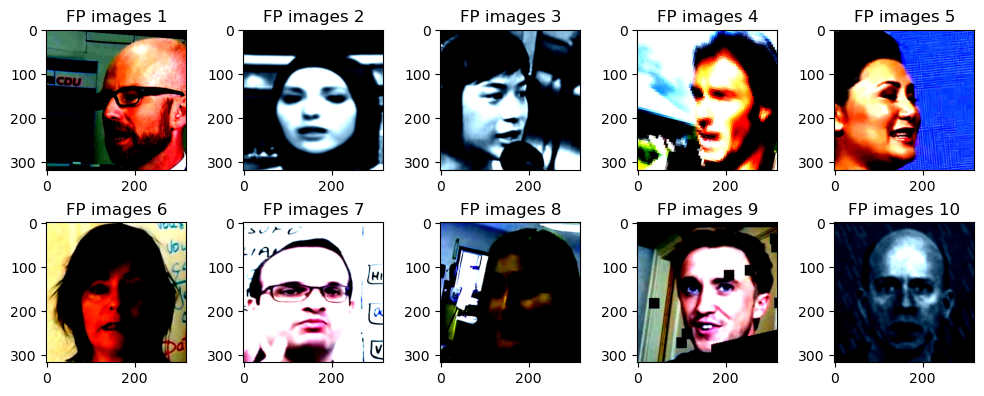

Our transformation did not cover fully the transformations applied in the dataset. For example, we observed that most FP and FN images are transformed by increasing the saturation or contrast. Hence, we have made certain adjustment to the orginial transformation `transform2`. `transform3` now contains a revised set of transformations.

#### **4.3. Data Augmentation Improvement**

Based on the result of misclassified images in the failure analysis, We defined another set of transformations in `transform3`, hoping for better regularization.

In [ ]:
# insert code here
transforms = {
    "transform1": A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.4659, 0.4310, 0.4056), std=(0.2161, 0.2032, 0.1986)),
            ToTensorV2(),
        ]
    ),
    "transform2": A.Compose([
            A.GaussNoise(p=0.1),
            A.GaussianBlur(p=0.1),
            A.CoarseDropout(max_height=16, max_width=16),
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
    ]),
    "transform3": A.Compose([
            A.GaussNoise(p=0.1),
            A.GaussianBlur(p=0.1),
            A.ZoomBlur(p=0.1),
            A.HueSaturationValue(p=0.1),
            A.RandomBrightnessContrast(p=0.2),
            A.CoarseDropout(max_height=16, max_width=16),
            A.ChannelShuffle(p=0.1),
            A.HueSaturationValue(p=0.2),
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
    ]),
    "test_transform": A.Compose(
        [
            A.Normalize(mean=(0.4659, 0.4310, 0.4056), std=(0.2161, 0.2032, 0.1986)),
            ToTensorV2(),
        ]
    ),
}

In [ ]:
#  DATASET BUILDING & LOADING
if MODE == 'train':
    train_ds = ImageFolder(target_folder+'/train', transform=transforms["transform3"], classification_mode='multiclass')
    test_ds = ImageFolder(target_folder+'/test', transform=transforms["test_transform"], classification_mode='multiclass')
    train_dataloader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True
    )
    test_dataloader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=True
    )

In [ ]:
# FOR TA:  Define the dataset and dataloaders
test_ds = ImageFolder(TEST_SET_PATH, transform=transforms["test_transform"], classification_mode='multiclass')
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

Result obtained from resnet18 with new transformation:

### **5. Model Selection**
According to the drawback of the baseline model, we do experiments on multiple models. For the experiments process, we will follows the method we use in the `resnet18` training above.

Here we list some experiment results of some model with good test set performance:

#### **5.1. EfficientNet_v2_s**
|Indicator | Value|
|-------------|--------|
|Accuracy | 97.79424|
|Recall | 97.75024|
|Precision | 97.8779|
|AUC | 97.79467|
|Evaluation Score | 97.79454|

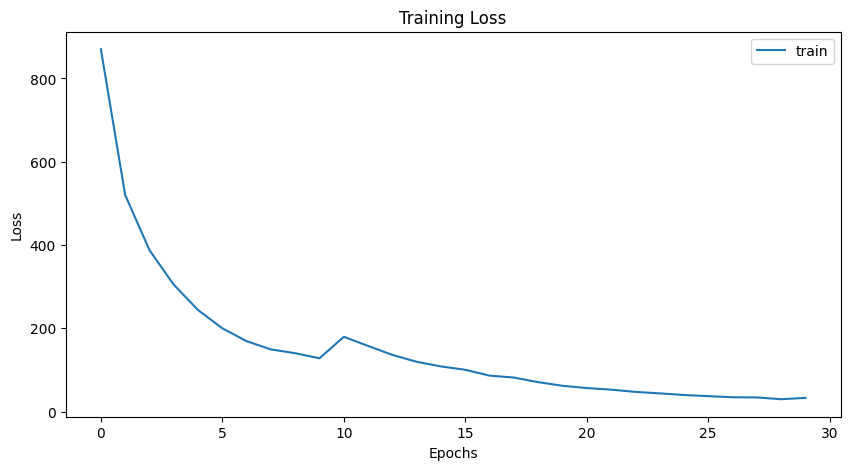 
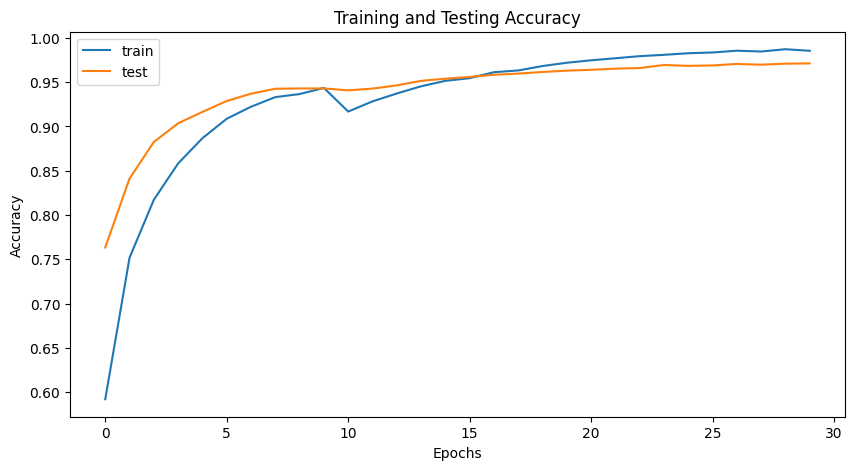 
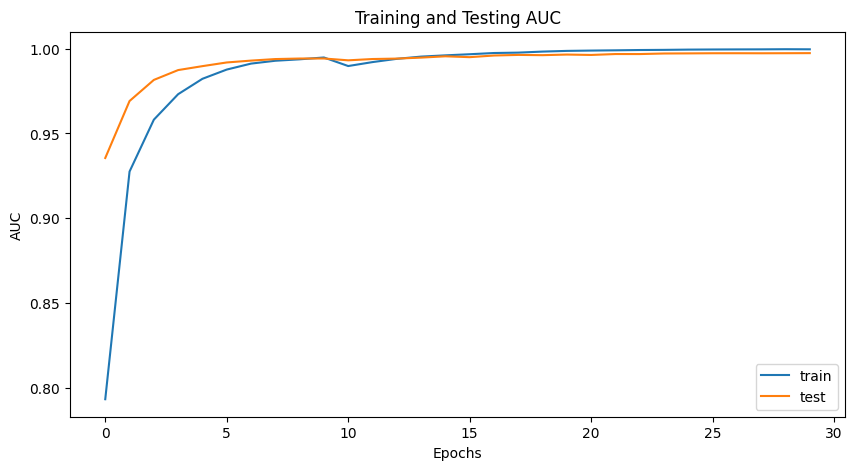

#### 5.2. **EfficientNet_v2_m**
|Indicator | Value|
|-------------|--------|
|Accuracy| 97.61317|
|Recall| 96.60906|
|Precision| 98.63515|
|AUC| 97.62302|
|Evaluation Score| 97.62006|

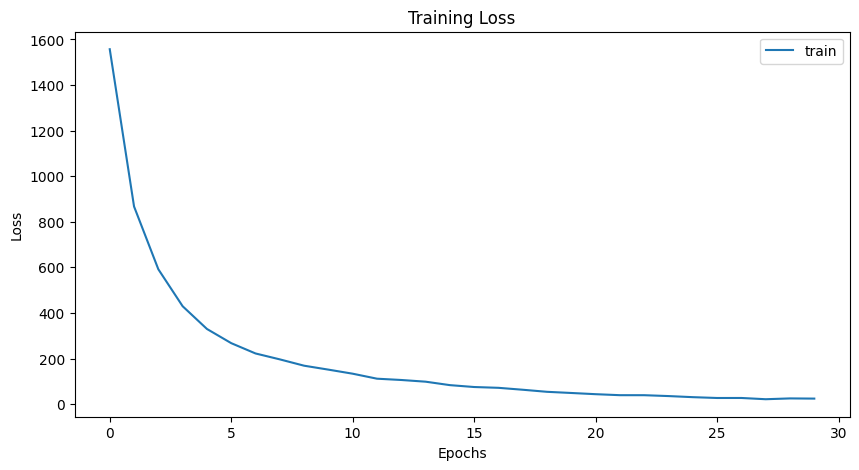
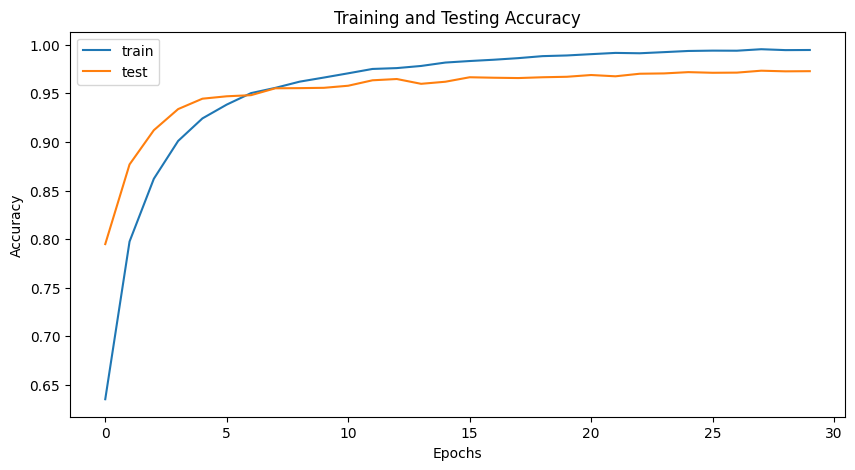
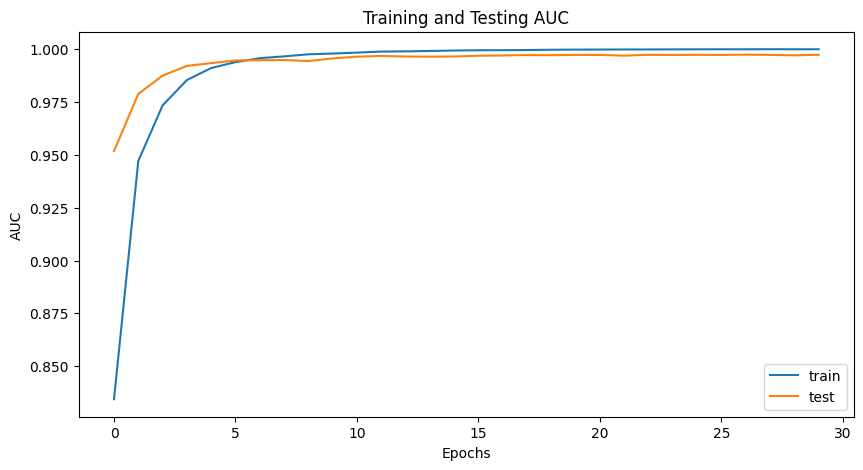

#### **5.3. EfficientNet_v2_l**
|Indicator | Value|
|-------------|--------|
|Accuracy| 98.02469|
|Recall| 97.52201|
|Precision| 98.55025|
|AUC| 98.02962|
|Evaluation Score| 98.02814|

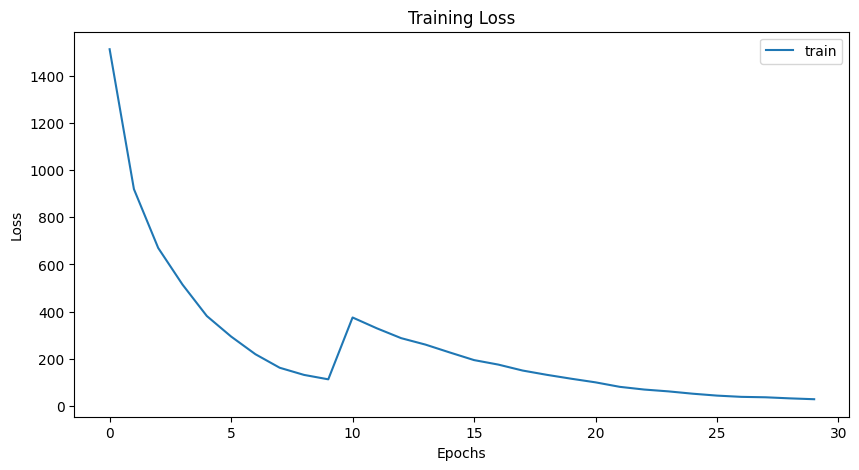 
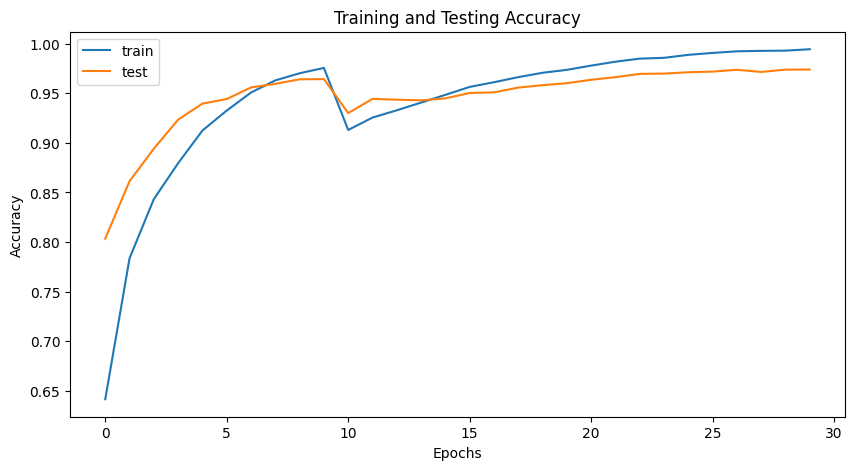 
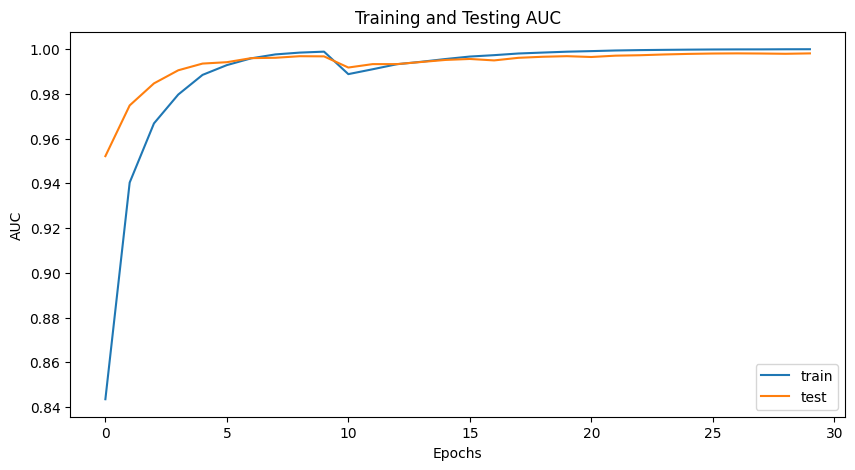

#### **5.4. SE_ResNeXt**
|Indicator | Value|
|-------------|--------|
|Accuracy| 94.91358|
|Recall| 93.60939|
|Precision| 96.21314|
|AUC| 94.92637|
|Evaluation Score| 94.92253|

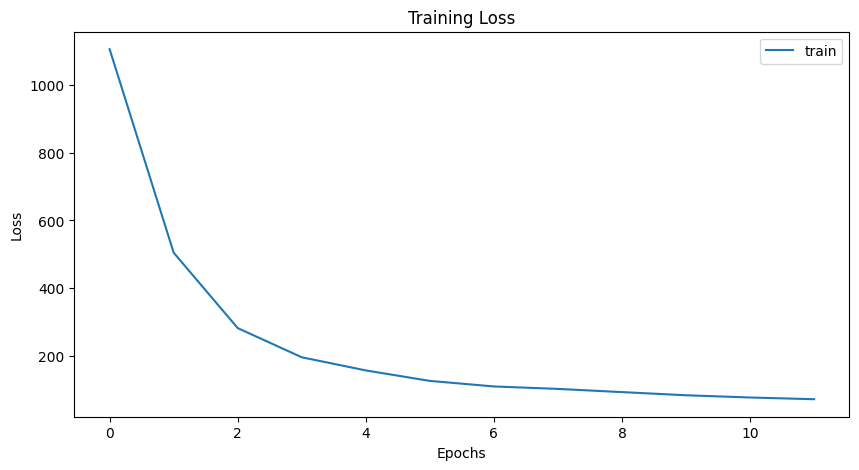
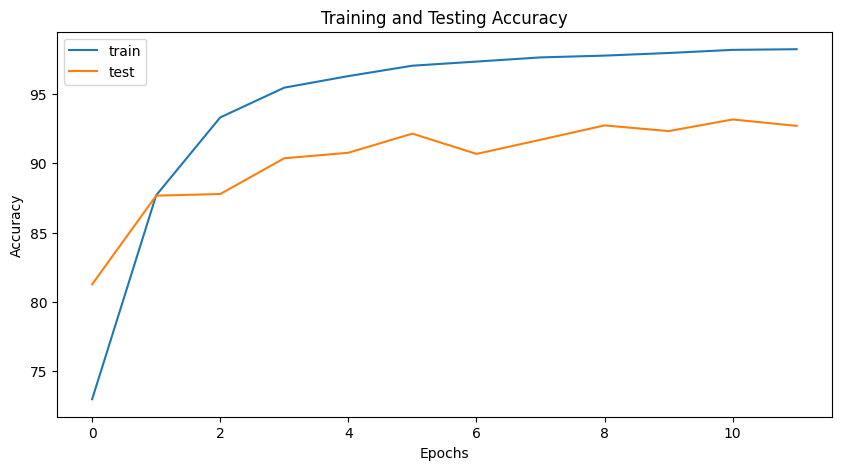 
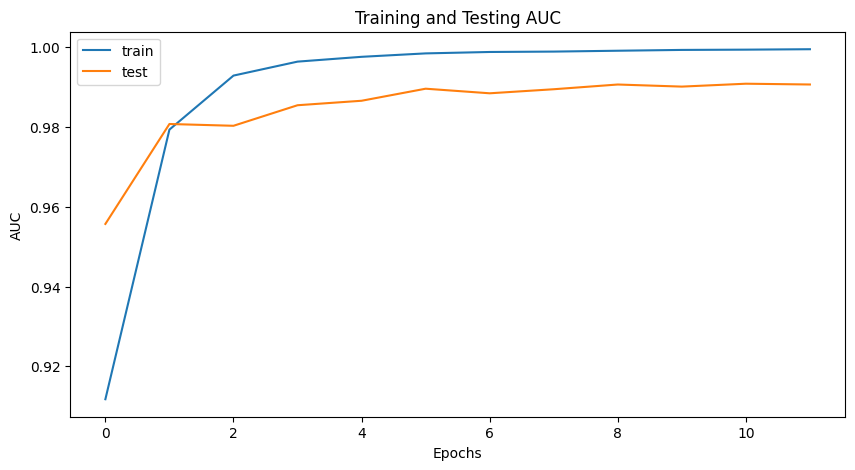

#### **5.5. ConvNeXt**

|Indicator | Value|
|-------------|--------|
|Accuracy| 96.52675|
|Recall| 95.69612|
|Precision| 97.3789|
|AUC| 96.5349|
|Evaluation Score| 96.53245|

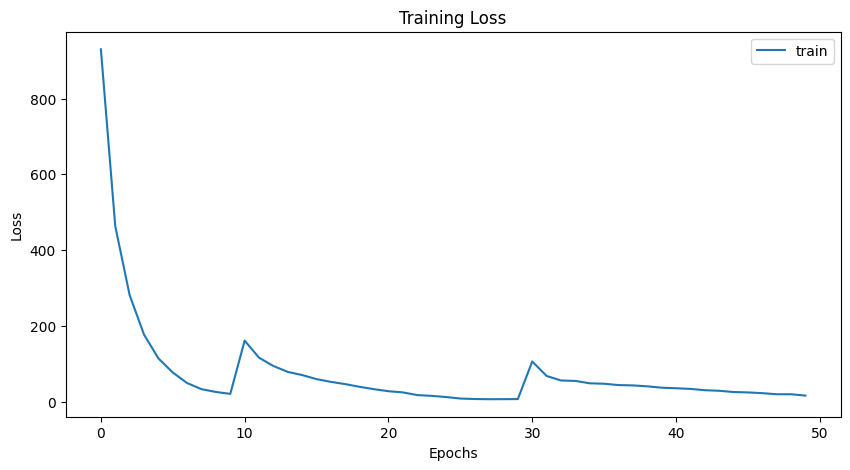 
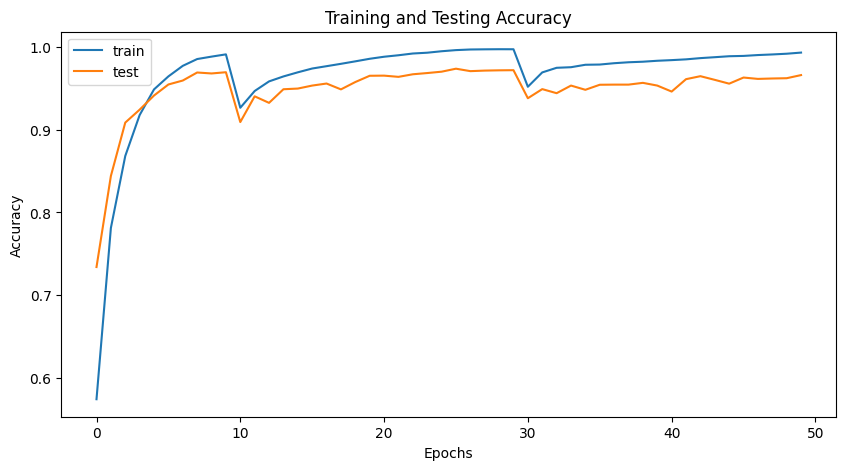
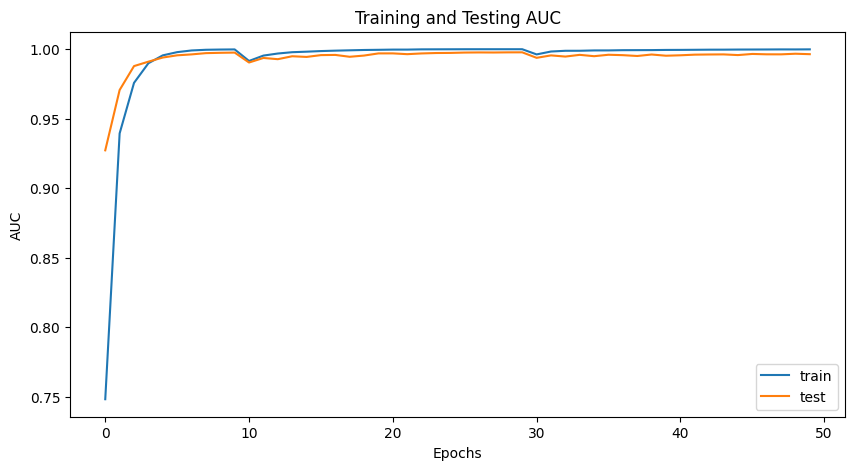

#### **5.6. ViT_b_16**
|Indicator | Value|
|-------------|--------|
|Accuracy| 96.65844|
|Recall| 95.10923|
|Precision| 98.21549|
|AUC| 96.67363|
|Evaluation Score| 96.66907|

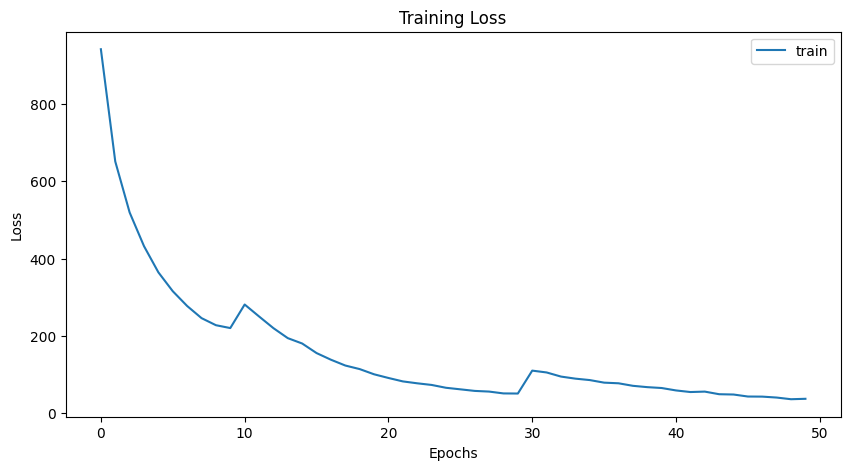
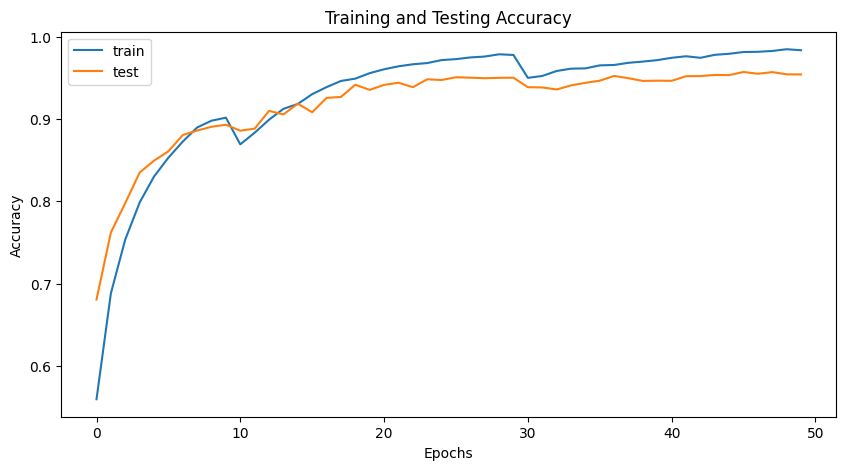 
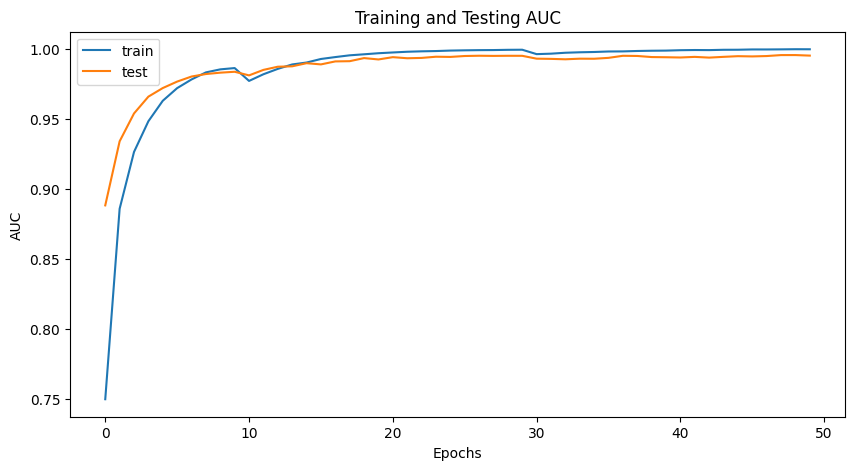 

### **6. Experiments**
#### **6.1. Model Ensemble**

|Models Included                                  | Accuracy | Recall   | Precision | AUC     | Evaluation Score |
|--------------------------------------------------|----------|----------|-----------|---------|-----------------|
| EfficientNet_V2_S, M, L, ViT_B_16, ResNeXt       | 98.41975 | 97.42419 | 99.43428  | 98.42952| 98.42659        |
| EfficientNet_V2_S, M, L, ViT_B_16, ConvNeXt_B... | 98.38683 | 97.39159 | 99.401    | 98.39659| 98.39366        |
| EfficientNet_V2_S, M, L, ResNeXt, ConvNeXt_B... | 98.28807 | 97.26117 | 99.334    | 98.29814| 98.29512        |
| EfficientNet_V2_M, L, ViT_B_16, ResNeXt, Con... | 98.28807 | 97.19596 | 99.3998   | 98.29878| 98.29556        |
| EfficientNet_V2_S, M, L, ViT_B_16, ResNeXt     | 98.30453 | 97.35898 | 99.26862  | 98.3138 | 98.31102        |
| EfficientNet_V2_S, L, ViT_B_16, ResNeXt, Con... | 98.35391 | 97.29377 | 99.43352  | 98.36431| 98.36119        |
| All Models | 98.40329 | 97.42419 | 99.4012   | 98.41289| 98.41001        |

In [ ]:
# insert code here
class Ensemble(nn.Module):
    def __init__(self, models):
        super(Ensemble, self).__init__()
        self.models = [model.to(device) for model in models]
    
    def forward(self, x):
        probs = [torch.softmax(model(x), dim=1) for model in self.models]
        mean = torch.mean(torch.stack(probs), dim=0)
        return mean

#### **6.2 Upsampling**
Most deepfake competition are done using deepfaked videos. We tried to take advantage of our medium of deepfake classification on images by preforming image enhancements. Our intuition said that by increasing the resolution of our images the model would be able to detect more subtle details.
We upsampled the images using bicubic interpolation,

```python
def upsample_image(image_path):
    image = Image.open(image_path)

    original_width, original_height = image.size

    new_width = int(original_width * 1.5)
    new_height = int(original_height * 1.5)

    upsampled_image = image.resize((new_width, new_height), Image.Resampling.BICUBIC)

    upsampled_image.save(image_path)
```

Result: Visually the upsamples images look clearer than the originals, however while the upsampled images improved preformance on our baseline ResNet18, it actaully hurt preformance on a better preforming model EfficientNetV2_s. We believe this is due to the upsampling algorithm increasing the image size thus requiring much more training time to converge. We did not have time to retrain all our models on the higher resolution images thus omitted it from our final solution.

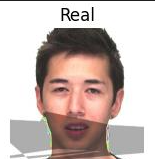

### 6.3 Image Augmentation during Inference

Again we wanted to take advantage of our medium by improving the quality of our images during inference. From our failture analysis we noticed that alot of misclassications happened when the image was too bright or too dark. We added a function to increase the brightness if it was too dark or decrease if it was too bright.

Increase brightness psudocode
```python
def IncreaseBrightness(image):
    mean = image.flatten().mean()
    if mean > 1: #note: our images are normalized
        increase brightness of image
    elif mean < 0:
        decrease brightness of image
    return image
```

Result: This resulted in worse preformance and signficiantly longer inference times. We believe this is because adding or removing a fixed amout of brightness to an image did not reveal anything important, also we did not apply this technique on the training set, so this augmentation might have lead to unfamiliar looking images.

### **7. Submission**
#### **7.1. Test Mode**

**Test mode functions**

In [ ]:
def download_and_extract_models():
    if not os.path.exists("./models_cs4487_team6.zip"):
        url = "https://drive.google.com/uc?id=13POOlNENsE2DLrM1VWzHUS1rav5r3RBm&confirm=t&uuid=892eddc8-3f11-4952-9215-875676ae526d"
        output = "./models_cs4487_team6.zip"
        gdown.download(url, output, quiet=False)
    if not os.path.exists('./models_cs4487_team6'):
        os.makedirs('models_cs4487_team6')
        with zipfile.ZipFile('./models_cs4487_team6.zip', "r") as zip_ref:
            zip_ref.extractall('./models_cs4487_team6')

In [ ]:
def load_model(model, model_dir, model_id):
    model_path = os.path.join(model_dir, model_id + ".pth")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

class ResizeLayer(nn.Module):
    def __init__(self, size):
        super(ResizeLayer, self).__init__()
        self.size = size

    def forward(self, x):
        return F.interpolate(x, size=self.size, mode='bilinear', align_corners=False)

**Test mode execution**

In [ ]:
if MODE == 'test':
    download_and_extract_models()

In [ ]:
if MODE == 'test':
    
    ssl._create_default_https_context = ssl._create_unverified_context

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # # SE-ResNeXt
    model_ser = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained="imagenet")
    model_ser.last_linear = nn.Linear(
        in_features=32768, out_features=6, bias=True
    )

    # LOAD OTHER MODELS HERE

    model_es = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    model_es.classifier[1] = nn.Linear(
        in_features=model_es.classifier[1].in_features, out_features=6, bias=True
    )

    model_em = models.efficientnet_v2_m(weights="IMAGENET1K_V1")
    model_em.classifier[1] = nn.Linear(
        in_features=model_em.classifier[1].in_features, out_features=6, bias=True
    )
    model_el = models.efficientnet_v2_l(weights="IMAGENET1K_V1")
    model_el.classifier[1] = nn.Linear(
        in_features=model_em.classifier[1].in_features, out_features=6, bias=True
    )

    model_vit = models.vit_b_16(weights="IMAGENET1K_V1")
    model_vit.heads[0] = nn.Linear(
        in_features=model_vit.heads[0].in_features, out_features=6, bias=True
    )

    model_conv = timm.create_model("convnext_base_in22ft1k", pretrained=True, num_classes=6)

    ResNeXt = load_model(model_ser, "./models_cs4487_team6/", "best_se_resnext50")
    EfficientNet_V2_S = load_model(model_es, "./models_cs4487_team6/", "best_efficientnet_v2_s")
    EfficientNet_V2_M = load_model(model_em, "./models_cs4487_team6/", "best_efficientnet_v2_m")
    EfficientNet_V2_L = load_model(model_el, "./models_cs4487_team6/", "best_efficientnet_v2_l")
    ConvNeXt_B_in22ft1k = load_model(model_conv, "./models_cs4487_team6/", "best_convnext_base_in22ft1k")
    ViT_B_16 = load_model(model_vit, "./models_cs4487_team6/", "best_vit_b_16")

    ViT_B_16 = nn.Sequential(ResizeLayer((224, 224)), ViT_B_16)

    models_list = [
        EfficientNet_V2_S,
        EfficientNet_V2_M,
        EfficientNet_V2_L,
        ViT_B_16,
        ResNeXt,
        ConvNeXt_B_in22ft1k,
    ]
    ensemble = Ensemble(models_list)

    # insert code here
    X_test, y_hat, y_pred, accuracy, recall, precision, auc = test(ensemble, test_dataloader)
    print(f"Evaluation Score: {0.7 * auc + 0.3 * accuracy}")



#### **7.2. Train Mode**

**Train mode functions**

In [ ]:
def run(params_list):
    for i, params in enumerate(params_list):
        model_id = params["model_id"]
        # print("training model: ", params["model_id"], " optimizer: ", params["optimizer"], " scheduler: ", params["scheduler"], " num_epochs: ", params["num_epochs"])
        #remove to_train from params
        params.pop("to_train")
        print("training model: ", params["model_id"])
        records = train_model(**params)
        print("----------------------------------")

In [ ]:
def create_experiment(params_list, model, optimizer, scheduler, model_id, train_dataloader, test_dataloader, num_epochs=30, to_train=True):
    params_temp = {
        "to_train": to_train,
        "model": model,
        "num_epochs": num_epochs,
        "optimizer": optimizer,
        "criterion": nn.CrossEntropyLoss(),
        "scheduler": scheduler,
        "train_dataloader": train_dataloader,
        "test_dataloader": test_dataloader,
        "model_id": model_id,
    }
    params_list.append(params_temp)

In [ ]:
if MODE == 'train':
    params_list = []
    model_id_list = []
    ####################################################################################################################################
    # efficientnet_v2_s
    model = models.efficientnet_v2_s(weights="IMAGENET1K_V1", drop_rate=0.2)
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=6, bias=True)
    model_id = "efficientnet_v2_s"
    model_id_list.append(model_id)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.005)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    epoches = 30
    # epoches = 1
    create_experiment(params_list, model, optimizer, scheduler, model_id, train_dataloader, test_dataloader, num_epochs=epoches, to_train=True)
    # efficientnet_v2_l
    model = models.efficientnet_v2_l(weights="IMAGENET1K_V1", drop_rate=0.2)
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=6, bias=True)
    model_id = "efficientnet_v2_l"
    model_id_list.append(model_id)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.005)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    epoches = 30
    # epoches = 1
    create_experiment(params_list, model, optimizer, scheduler, model_id, train_dataloader, test_dataloader, num_epochs=epoches, to_train=True)
    # efficientnet_v2_m
    model = models.efficientnet_v2_m(weights="IMAGENET1K_V1", drop_rate=0.2)
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=6, bias=True)
    model_id = "efficientnet_v2_m"
    model_id_list.append(model_id)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.005)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2, eta_min=1e-6)
    epoches = 30
    # epoches = 1
    create_experiment(params_list, model, optimizer, scheduler, model_id, train_dataloader, test_dataloader, num_epochs=epoches, to_train=True)
    # vit_b_16
    model = models.vit_b_16(weights="IMAGENET1K_V1")
    model.heads[0] = nn.Linear(in_features=model.heads[0].in_features, out_features=6, bias=True)
    model = nn.Sequential(
        ResizeLayer((224, 224)),
        model
    )
    model_id = "vit_b_16"
    model_id_list.append(model_id)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.005)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    epoches = 50
    # epoches = 1
    create_experiment(params_list, model, optimizer, scheduler, model_id, train_dataloader, test_dataloader, num_epochs=epoches, to_train=True)
    # se_resnext50_32x4d
    model_name = "se_resnext50_32x4d"
    model_id_list.append(model_id)
    model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained="imagenet")
    num_features = model.last_linear.out_features
    model.last_linear = nn.Linear(32768, 6)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.005)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)
    epoches = 30
    # epoches = 1
    create_experiment(params_list, model, optimizer, scheduler, model_id, train_dataloader, test_dataloader, num_epochs=epoches, to_train=True)
    # convnext_base_in22ft1k
    model = timm.create_model('convnext_base_in22ft1k', pretrained=True, num_classes=6, drop_rate=0.2)
    model_id = "convnext_base_in22ft1k"
    model_id_list.append(model_id)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.005)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    epoches = 50
    # epoches = 1
    create_experiment(params_list, model, optimizer, scheduler, model_id, train_dataloader, test_dataloader, num_epochs=epoches, to_train=True)
    ####################################################################################################################################



**Train mode execution**

In [ ]:
if MODE == 'train':
    print("models to train:" , model_id_list)
    run(params_list)

In [ ]:
if MODE == 'train':
    ssl._create_default_https_context = ssl._create_unverified_context

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # # SE-ResNeXt
    model_ser = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained="imagenet")
    model_ser.last_linear = nn.Linear(
        in_features=32768, out_features=6, bias=True
    )

    # LOAD OTHER MODELS HERE

    model_es = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    model_es.classifier[1] = nn.Linear(
        in_features=model_es.classifier[1].in_features, out_features=6, bias=True
    )

    model_em = models.efficientnet_v2_m(weights="IMAGENET1K_V1")
    model_em.classifier[1] = nn.Linear(
        in_features=model_em.classifier[1].in_features, out_features=6, bias=True
    )
    model_el = models.efficientnet_v2_l(weights="IMAGENET1K_V1")
    model_el.classifier[1] = nn.Linear(
        in_features=model_em.classifier[1].in_features, out_features=6, bias=True
    )

    model_vit = models.vit_b_16(weights="IMAGENET1K_V1")
    model_vit.heads[0] = nn.Linear(
        in_features=model_vit.heads[0].in_features, out_features=6, bias=True
    )

    model_conv = timm.create_model("convnext_base_in22ft1k", pretrained=True, num_classes=6, drop_rate=0.2)

    ResNeXt = load_model(model_ser, "best_se_resnext50")
    EfficientNet_V2_S = load_model(model_es, "", "best_efficientnet_v2_s")
    EfficientNet_V2_M = load_model(model_em, "", "best_efficientnet_v2_m")
    EfficientNet_V2_L = load_model(model_el, "", "best_efficientnet_v2_l")
    ConvNeXt_B_in22ft1k = load_model(model_conv, "", "best_convnext_base_in22ft1k")
    ViT_B_16 = load_model(model_vit, "", "best_vit_b_16")

    ViT_B_16 = nn.Sequential(ResizeLayer((224, 224)), ViT_B_16)

    models_list = [
        EfficientNet_V2_S,
        EfficientNet_V2_M,
        EfficientNet_V2_L,
        ViT_B_16,
        ResNeXt,
        ConvNeXt_B_in22ft1k,
    ]
    ensemble = Ensemble(models_list)

    # insert code here
    X_test, y_hat, y_pred, accuracy, recall, precision, auc = test(ensemble, test_dataloader)

    print(f"Evaluation Score: {0.7 * auc + 0.3 * accuracy}")


### Appendix I. References
[1] Kede Ma, CS4487 Machine Learning, Lecture 10.2

[1] Zhiyuan Yan, Yong Zhuang, Xinhang Yuan, Siwei Lyu and Baoyuan Wu. DeepfakeBench: A Comprehensive Benchmark of
Deepfake Detection. arXiv preprint arXiv:2307.01426, 2023.

[2] Deepfake detection (DFDC) solution by selimsef. https://github.com/selimsef/dfdc_deepfake_challenge. Accessed: 2023-12-10. 

[3] Deeper Forensics Challenge Solution by Baoying Chen, Peiyu Zhuang, Sili Li https://github.com/beibuwandeluori/DeeperForensicsChallengeSolution.  Accessed: 2023-12-10. 